## DQC layer 

### **Kaggle task data holder:**

https://www.kaggle.com/competitions/competitive-data-science-predict-future-sales

### **Description:**

- Your current goal is get familiar with the data you were given, so in this task you should create a notebook that would show all data you have
- The second task is Data Quality Check layer. Since you would work a lot with your data, it would be useful to create a dqc notebook that would be used to mark all possible issues that your data have:
    - Outliers
    - Poor dynamic all a lot of missing information
    - Data inconsistency
- Note: the main question you should answer in order to understand DQC layer is where is it used, so we use DQC in order to create ETL layer or conduct a data extraction

### **Possible Tools:**

- Data visualisation - seaborn, plotly, matplotlib
- Data processing - pandas, numpy, statsmodels, scikit-learn

## In this notebook I only check for various possible data issues. All the needed data transformations are performed within the ETL layer

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append('../')
import scripts.dqc as dqc # dqc.py module

In [7]:
# !kaggle competitions download -c competitive-data-science-predict-future-sales

competitive-data-science-predict-future-sales.zip: Skipping, found more recently modified local copy (use --force to force download)


In [8]:
# !unzip competitive-data-science-predict-future-sales.zip -d ../data

Archive:  competitive-data-science-predict-future-sales.zip
  inflating: ../data/item_categories.csv  
  inflating: ../data/items.csv       
  inflating: ../data/sales_train.csv  
  inflating: ../data/sample_submission.csv  
  inflating: ../data/shops.csv       
  inflating: ../data/test.csv        


### **File descriptions**

- sales_train.csv - the training set. Daily historical data from January 2013 to October 2015.
- test.csv - the test set. You need to forecast the sales for these shops and products for November 2015.
- sample_submission.csv - a sample submission file in the correct format.
- items.csv - supplemental information about the items/products.
- item_categories.csv  - supplemental information about the items categories.
- shops.csv- supplemental information about the shops.

### **Data fields**

- ID - an Id that represents a (Shop, Item) tuple within the test set
- shop_id - unique identifier of a shop
- item_id - unique identifier of a product
- item_category_id - unique identifier of item category
- item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
- item_price - current price of an item
- date - date in format dd/mm/yyyy
- date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
- item_name - name of item
- shop_name - name of shop
- item_category_name - name of item category

## 1. Load data into dataframes and show data structure

In [9]:
train_df = pd.read_csv('../data/sales_train.csv')
test_df = pd.read_csv('../data/test.csv')
items_df = pd.read_csv('../data/items.csv')
categories_df = pd.read_csv('../data/item_categories.csv')
shops_df = pd.read_csv('../data/shops.csv')

### Look at **train_df**

In [5]:
train_df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [6]:
print(train_df.info(), '\n\n')
print(train_df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB
None 


       date_block_num       shop_id       item_id    item_price  item_cnt_day
count    2.935849e+06  2.935849e+06  2.935849e+06  2.935849e+06  2.935849e+06
mean     1.456991e+01  3.300173e+01  1.019723e+04  8.908532e+02  1.242641e+00
std      9.422988e+00  1.622697e+01  6.324297e+03  1.729800e+03  2.618834e+00
min      0.000000e+00  0.000000e+00  0.000000e+00 -1.000000e+00 -2.200000e+01
25%      7.000000e+00  2.200000e+01  4.476000e+03  2.490000e+02  1.000000e+00
50%      1.400000e+01  3.100000e+01  9.343000e+03  3.990000e+02  1.000000e+00
75%      2.300000e+01  4.700000e+01  1

In [7]:
is_integer = train_df['item_cnt_day'].apply(lambda x: x.is_integer())
if is_integer.sum() == len(train_df):
    print("all item_cnt_day values are actually integers")

all item_cnt_day values are actually integers


1)All numeric columns' values are less than **10^6** and 2) **item_cnt_day** feature is intended to be integer,
 
so we should transform dtypes in ETL

### Look at **test_df**

In [8]:
test_df.head() 

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [9]:
print(test_df.info(), '\n\n')
print(test_df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   ID       214200 non-null  int64
 1   shop_id  214200 non-null  int64
 2   item_id  214200 non-null  int64
dtypes: int64(3)
memory usage: 4.9 MB
None 


                  ID        shop_id        item_id
count  214200.000000  214200.000000  214200.000000
mean   107099.500000      31.642857   11019.398627
std     61834.358168      17.561933    6252.644590
min         0.000000       2.000000      30.000000
25%     53549.750000      16.000000    5381.500000
50%    107099.500000      34.500000   11203.000000
75%    160649.250000      47.000000   16071.500000
max    214199.000000      59.000000   22167.000000


### Look at **items_df**

In [10]:
items_df.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [11]:
print(items_df.info(), '\n\n')
print(items_df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   item_name         22170 non-null  object
 1   item_id           22170 non-null  int64 
 2   item_category_id  22170 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 519.7+ KB
None 


           item_id  item_category_id
count  22170.00000      22170.000000
mean   11084.50000         46.290753
std     6400.07207         15.941486
min        0.00000          0.000000
25%     5542.25000         37.000000
50%    11084.50000         40.000000
75%    16626.75000         58.000000
max    22169.00000         83.000000


### Look at **categories_df**

In [12]:
categories_df.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [13]:
print(categories_df.info(), '\n\n')
print(categories_df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   item_category_name  84 non-null     object
 1   item_category_id    84 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.4+ KB
None 


       item_category_id
count         84.000000
mean          41.500000
std           24.392622
min            0.000000
25%           20.750000
50%           41.500000
75%           62.250000
max           83.000000


### Look at **shops_df**

In [14]:
shops_df.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [15]:
print(shops_df.info(), '\n\n')
print(shops_df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   shop_name  60 non-null     object
 1   shop_id    60 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB
None 


         shop_id
count  60.000000
mean   29.500000
std    17.464249
min     0.000000
25%    14.750000
50%    29.500000
75%    44.250000
max    59.000000


### **test_df, items_df, categories_df, shops_df** sets are all fine

## 2. Check for missing values

In [16]:
dataframes = [train_df, test_df, items_df, categories_df, shops_df]

for df in dataframes:
    dqc.check_missing_data(df)

No missing data found
No missing data found
No missing data found
No missing data found
No missing data found


## 3. Search for duplicates

In [17]:
for df in dataframes:
    dqc.check_duplicates(df)

Number of duplicated rows: 12
Number of duplicated rows: 0
Number of duplicated rows: 0
Number of duplicated rows: 0
Number of duplicated rows: 0


In [18]:
train_df.drop_duplicates(inplace=True)

In [19]:
for df in dataframes:
    dqc.check_duplicates(df)

Number of duplicated rows: 0
Number of duplicated rows: 0
Number of duplicated rows: 0
Number of duplicated rows: 0
Number of duplicated rows: 0


## 4. Check data inconsistency
Search for possible negative values

In [20]:
dqc.check_negative_values(train_df, 'item_cnt_day')

0.25055835751434935 percent of values are negative


This result may possibly mean that sales_train.csv file also contains data about items returned to shops. Even in this case such information is useless as it doesn't affect total sales for every product

In [21]:
dqc.check_negative_values(train_df, 'item_price')

3.4061766926909916e-05 percent of values are negative


All these rows can be deleted later

## 5. Check ids' and names' uniqueness for supplementary sets

In [22]:
dqc.check_unique_ids(categories_df, 'item_category_name', 'item_category_id')

All names and ids are unique


In [23]:
dqc.check_unique_ids(shops_df, 'shop_name', 'shop_id')

All names and ids are unique


In [24]:
dqc.check_unique_ids(items_df, 'item_name', 'item_id')

All names and ids are unique


## 6. Search for outliers in **train_df**

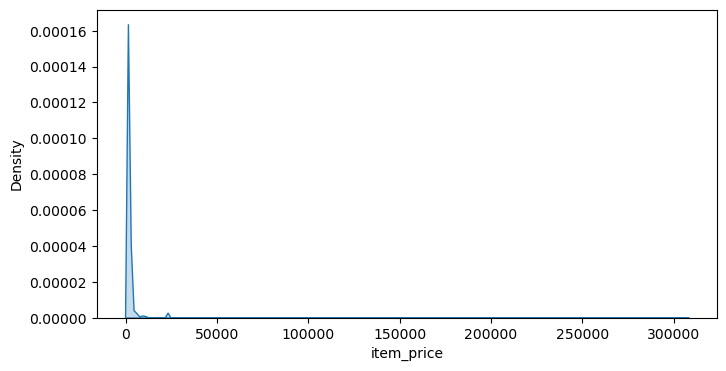

In [25]:
dqc.plot_distribution(train_df, 'item_price')

In [26]:
dqc.find_outliers(train_df, 'item_price')

IQR: 750.0
Number of outliers: 258942
Percent of outliers: 8.820022051587909
Upper bound value: 2124.0, lower bound value: -876.0
Min value: -1.0, Max value: 307980.0


In order to decide whether to delete outliers or not it's good to understand the reasons of their presence. It would be easier to merge all information into one dataframe, so outliers will be discussed later in ETL layer

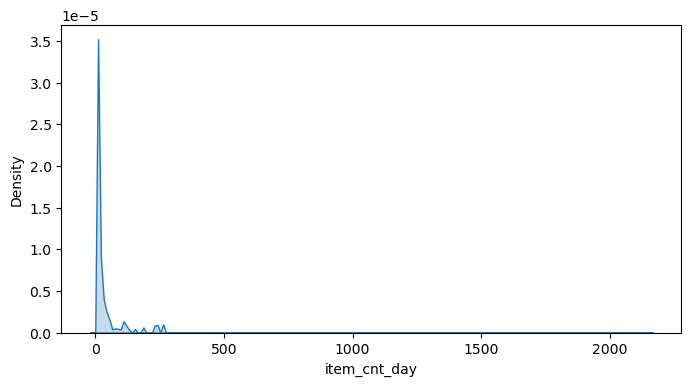

In [28]:
dqc.plot_distribution(train_df, 'item_cnt_day')

In [27]:
dqc.find_outliers(train_df, 'item_cnt_day')

IQR: 0.0
Number of outliers: 306477
Percent of outliers: 10.439148142458572
Upper bound value: 1.0, lower bound value: 1.0
Min value: -22.0, Max value: 2169.0


## **Conclusion**

After data quality check process it's clear that some transformations should be done:

1. Change dtypes for some **train_df** columns
2. Delete **train_df** rows with negative values
3. Merge **train_df** with **items_df, categories_df, shops_df**. Do the same with **test_df**